# Tutorial 4: Align multiple ST datasets with non-overlapping domain types

We use STANDS to align multiple ST datasets with non-overlapping domain types. Specifically, this experiment involves a normal breast tissue dataset (10x-hNB-v07) and two breast cancer datasets (10x-hBC-G2 &10x-hBC-H1) that have been curated to share all domain types, except for the cancer in situ and invasive cancer domains that are unique to 10x-hBC-G2 and 10x-hBC-H1.

## Loading package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import stands
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

## Reading ST data

We read the processed ST datasets. In the example, the demo datasets includes: 1) gene expression matrix in `adata.X`; 2) spatial coordinates in `adata.obsm['spatial']`; 3) histology image in `adata.uns['spatial']`. To make the model can read the data sucessfully, please ensure the same anndata structure as example.

In [3]:
path = [
    './HumanBreast/process/V07.h5ad',
    './HumanBreast/process/G2.h5ad',
    './HumanBreast/process/H1.h5ad'
]

adata_list = []
for p in path:
    adata = sc.read_h5ad(p)
    adata_list.append(adata)

In [4]:
adata_list

[AnnData object with n_obs × n_vars = 2086 × 3000
     obs: 'cell_type', 'batch', 'disease'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 467 × 3000
     obs: 'cell_type', 'batch', 'disease'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 613 × 3000
     obs: 'cell_type', 'batch', 'disease'
     uns: 'spatial'
     obsm: 'spatial']

## Converting data

For ST input, STANDS first needs to convert the anndata data into a graph, where nodes represent each spot and edges represent the adjacency relationship between two spots. In the example, the node features of the converted graph include the gene expression vector and image patch. Additionally, if the data has been preprocessed, you should set `preprocess=False`. It is worth noting that STANDS converts data in the case of multiple datasets in a slightly different way than a single dataset. 

In [5]:
# Anomaly detection data
ref_g = stands.read(adata_list[0], patch_size=64, n_genes=3000, preprocess=False)
tgt_g = stands.read_multi(adata_list[1:], patch_size=64, n_genes=3000, preprocess=False)

## Detecting anomaly domains

Due to the presence of domain-specific domain types (also treated as anomalies), STANDS first performs the anomaly detection module to identify these anomalies. After recording the results of the detection in `adata.obs['pred']`, it again constructs the data needed by the batch correction module

In [6]:
ADModel = stands.AnomalyDetect()
ADModel.fit(ref_g)

Begin to train the model on reference datasets...


Train Epochs: 100%|██████████| 10/10 [02:35<00:00, 15.57s/it, D_Loss=1.17, G_Loss=2.65]

Training has been finished.


In [7]:
scores, labels = ADModel.predict(tgt_g)

Detect anomalous spots on target dataset...
Anomalous spots have been detected.



In [8]:
adata_list[0].obs['pred'] = 0
adata_list[1].obs['pred'] = labels[0]
adata_list[2].obs['pred'] = labels[1]

In [9]:
adata_g = stands.read_multi(adata_list, patch_size=64, n_genes=3000, preprocess=False)

## Training the model

After inputting the converted data and generator into `fit`, STANDS starts to train the style-transfer GAN. After training, the corrected data will directly replace `adata.X`, and `fit` will automatically return `adata` as output.

In [10]:
BCModel = stands.BatchAlign(GPU='cuda:1')
adata = BCModel.fit(adata_g, ADModel.G)

Begin to find Kin Pairs between datasets...


Train Epochs: 100%|██████████| 1000/1000 [00:42<00:00, 23.30it/s, D_Loss=-.128, G_Loss=5.52]


Kin Pairs have been found.

Begin to correct spatial transcriptomics datasets...


Train Epochs: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it, D_Loss=0.172, G_Loss=1.71]

Datasets have been corrected.



## Evaluation

STANDS integrates several evaluation metrics in `stands.evaluate` for anomaly detection tasks, which can be used very easily and directly. Note that because of the presence of domain-specific domain types, if we need to explore the impact of their presence on the batch correction task, we need to remove them before calculating the metrics; this is because their presence itself greatly affects metrics such as BatchKL, and we should rather We should explore whether their presence affects the batch correction of domain-invariant domain types.

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2024-06-03 18:50:11.193214: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [12]:
metrics = ['ASW_type', '1-ASW_batch', 'BatchKL', 'iLISI', 'cLISI']
result = stands.evaluate(metrics, adata=adata, spaid='spatial', 
                         batchid='batch', typeid='cell_type', emb='X_umap')

In [13]:
pd.DataFrame(zip(metrics, result))

,0,1
0,ASW_type,0.567508
1,1-ASW_batch,0.967600
2,BatchKL,0.377476
3,iLISI,1.643172
4,cLISI,1.129224


## Visualization

We use the umap to visualise the results of batch alignment.

In [14]:
original = ad.concat(adata_list)
sc.pp.normalize_total(original)
sc.pp.log1p(original)
sc.pp.pca(original)
sc.pp.neighbors(original)
sc.tl.umap(original)

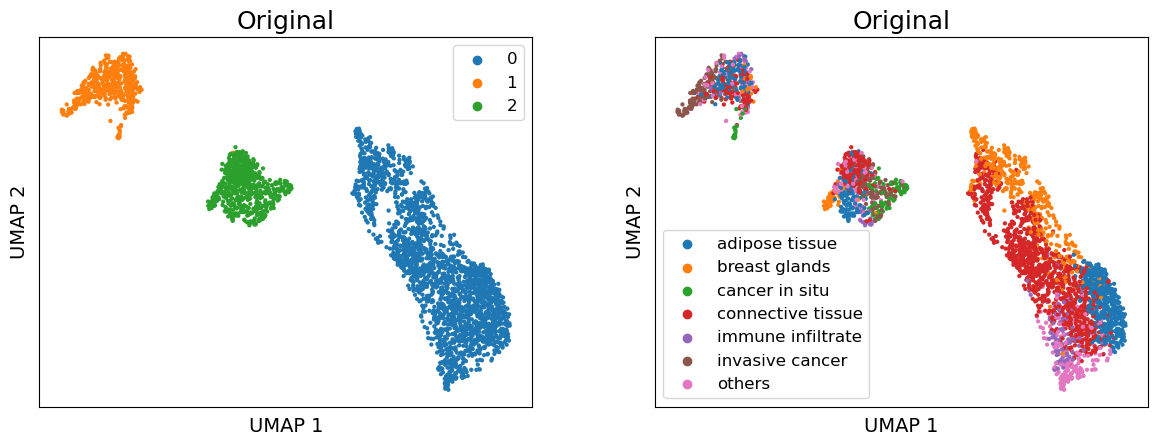

In [15]:
original.obs['batch'] = original.obs['batch'].astype('category')
ax = sc.pl.umap(original, color=['batch', 'cell_type'], show=False)

ax[0].legend(fontsize=12)
ax[0].set_title('Original', fontsize=18)
ax[0].set_xlabel('UMAP 1', fontsize=14)
ax[0].set_ylabel('UMAP 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('Original', fontsize=18)
ax[1].set_xlabel('UMAP 1', fontsize=14)
ax[1].set_ylabel('UMAP 2', fontsize=14)

plt.show()

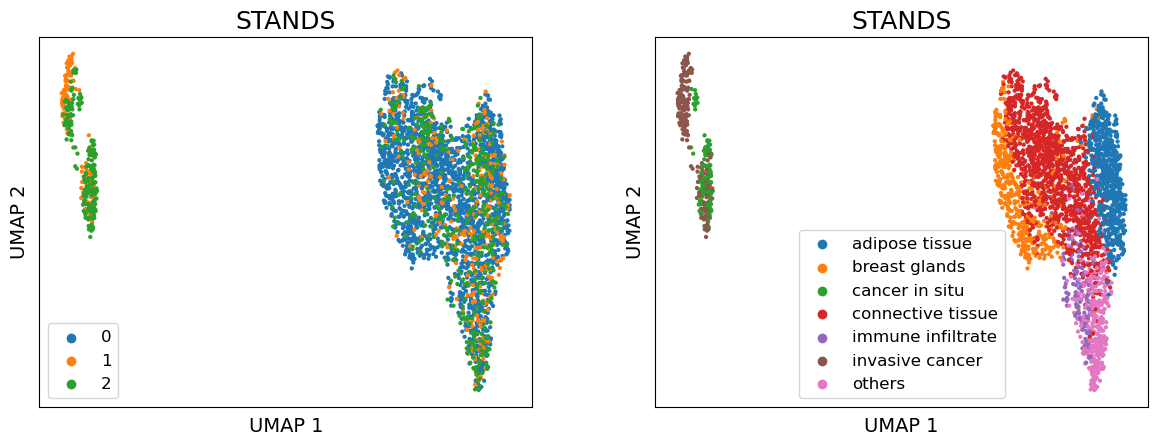

In [16]:
adata.obs['batch'] = adata.obs['batch'].astype('category')
ax = sc.pl.umap(adata, color=['batch', 'cell_type'], show=False)

ax[0].legend(fontsize=12)
ax[0].set_title('STANDS', fontsize=18)
ax[0].set_xlabel('UMAP 1', fontsize=14)
ax[0].set_ylabel('UMAP 2', fontsize=14)

ax[1].legend(fontsize=12)
ax[1].set_title('STANDS', fontsize=18)
ax[1].set_xlabel('UMAP 1', fontsize=14)
ax[1].set_ylabel('UMAP 2', fontsize=14)

plt.show()